In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/255.0, x_test/255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# CNN Classifier

In [2]:
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

cnn_model = build_cnn_model()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train, y_train_cat, epochs=5, batch_size=64, validation_data=(x_test, y_test_cat))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3651 - loss: 1.7348 - val_accuracy: 0.5450 - val_loss: 1.2711
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5767 - loss: 1.2072 - val_accuracy: 0.6083 - val_loss: 1.1255
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6334 - loss: 1.0531 - val_accuracy: 0.6419 - val_loss: 1.0177
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6704 - loss: 0.9662 - val_accuracy: 0.6616 - val_loss: 0.9758
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6916 - loss: 0.8933 - val_accuracy: 0.6773 - val_loss: 0.9466


# AlexNet Classifier

In [3]:
def build_alexnet_model():
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(32, 32, 3), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(384, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

alexnet_model = build_alexnet_model()
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
alexnet_model.fit(x_train, y_train_cat, epochs=5, batch_size=64, validation_data=(x_test, y_test_cat))


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.2754 - loss: 1.9117 - val_accuracy: 0.3463 - val_loss: 1.9091
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4738 - loss: 1.4742 - val_accuracy: 0.4764 - val_loss: 1.5036
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5412 - loss: 1.2986 - val_accuracy: 0.5234 - val_loss: 1.3815
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5933 - loss: 1.1717 - val_accuracy: 0.5664 - val_loss: 1.2685
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6316 - loss: 1.0738 - val_accuracy: 0.5741 - val_loss: 1.2892


# Pre-trained ResNet Model

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Preprocess function for ResNet
def preprocess_resnet(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    return image, label

# Create tf.data pipelines for batch-wise loading and resizing
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
test_ds = test_ds.map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load pretrained ResNet
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_resnet.trainable = False

# Define model
resnet_model = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile and train
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_model.fit(train_ds, epochs=5, validation_data=test_ds)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 187s 111ms/step - accuracy: 0.1330 - loss: 2.2919 - val_accuracy: 0.1902 - val_loss: 2.0982
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 169s 108ms/step - accuracy: 0.2345 - loss: 2.0250 - val_accuracy: 0.2571 - val_loss: 1.9617
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 185s 97ms/step - accuracy: 0.2578 - loss: 1.9542 - val_accuracy: 0.2774 - val_loss: 1.9242
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 154s 98ms/step - accuracy: 0.2758 - loss: 1.9184 - val_accuracy: 0.2980 - val_loss: 1.8834
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 217s 108ms/step - accuracy: 0.2959 - loss: 1.8822 - val_accuracy: 0.3058 - val_loss: 1.8590


# Pre-trained Inception Model

In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Resize + preprocess per sample (safe)
def preprocess_inception(image, label):
    image = tf.image.resize(image, (299, 299))
    image = inception_preprocess(image)
    return image, label

# Create tf.data pipeline (memory-safe)
BATCH_SIZE = 16  # Use small batch size for 299x299 inputs

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess_inception).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
test_ds = test_ds.map(preprocess_inception).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Load pre-trained InceptionV3
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_inception.trainable = False

# Build the model
inception_model = models.Sequential([
    base_inception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile and train
inception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.fit(train_ds, epochs=5, validation_data=test_ds)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 241s 72ms/step - accuracy: 0.1371 - loss: 2.2677 - val_accuracy: 0.2235 - val_loss: 2.0848
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 257s 73ms/step - accuracy: 0.2349 - loss: 2.0110 - val_accuracy: 0.2587 - val_loss: 1.9335
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 263s 73ms/step - accuracy: 0.2590 - loss: 1.9013 - val_accuracy: 0.2725 - val_loss: 1.8782
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 262s 73ms/step - accuracy: 0.2691 - loss: 1.8585 - val_accuracy: 0.2755 - val_loss: 1.8489
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 259s 72ms/step - accuracy: 0.2750 - loss: 1.8345 - val_accuracy: 0.2814 - val_loss: 1.8300


# Custom Model Architecture

In [7]:
def build_custom_model():
    model = models.Sequential([
        layers.Conv2D(16, (3,3), activation='relu', input_shape=(32,32,3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

custom_model = build_custom_model()
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model.fit(x_train, y_train_cat, epochs=5, batch_size=64, validation_data=(x_test, y_test_cat))


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3693 - loss: 1.7490 - val_accuracy: 0.5232 - val_loss: 1.3458
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5648 - loss: 1.2356 - val_accuracy: 0.6028 - val_loss: 1.1274
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6197 - loss: 1.0870 - val_accuracy: 0.6283 - val_loss: 1.0685
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6561 - loss: 0.9896 - val_accuracy: 0.6353 - val_loss: 1.0465
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6774 - loss: 0.9264 - val_accuracy: 0.6626 - val_loss: 0.9751


#  For CNN, AlexNet, or Custom Model

In [8]:
import matplotlib.pyplot as plt
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def test_model_prediction(model, x_test, y_test, class_names, num_samples=5):
    import random
    indices = random.sample(range(len(x_test)), num_samples)
    sample_images = x_test[indices]
    sample_labels = y_test[indices]

    predictions = model.predict(sample_images)

    for i in range(num_samples):
        plt.imshow(sample_images[i])
        plt.axis('off')
        true_label = class_names[int(sample_labels[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        plt.title(f"Predicted: {pred_label}, Actual: {true_label}")
        plt.show()

# Use this with:
# test_model_prediction(cnn_model, x_test, y_test, class_names)
# test_model_prediction(alexnet_model, x_test, y_test, class_names)
# test_model_prediction(custom_model, x_test, y_test, class_names)


#  For ResNet Model (224×224 resized)

In [9]:
def test_resnet_model(model, x_test_resized, y_test, class_names, num_samples=5):
    import random
    indices = random.sample(range(len(x_test_resized)), num_samples)
    sample_images = x_test_resized.numpy()[indices]
    sample_labels = y_test[indices]

    predictions = model.predict(sample_images)

    for i in range(num_samples):
        plt.imshow(sample_images[i].astype("uint8"))
        plt.axis('off')
        true_label = class_names[int(sample_labels[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        plt.title(f"Predicted: {pred_label}, Actual: {true_label}")
        plt.show()

# test_resnet_model(resnet_model, x_test_resized, y_test, class_names)


#  For Inception Model (299×299 + preprocessing)

In [10]:
def test_inception_model(model, x_test_inc, y_test, class_names, num_samples=5):
    import random
    indices = random.sample(range(len(x_test_inc)), num_samples)
    sample_images = x_test_inc.numpy()[indices]
    sample_labels = y_test[indices]

    preprocessed_images = inception_preprocess(sample_images)
    predictions = model.predict(preprocessed_images)

    for i in range(num_samples):
        plt.imshow(sample_images[i].astype("uint8"))
        plt.axis('off')
        true_label = class_names[int(sample_labels[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        plt.title(f"Predicted: {pred_label}, Actual: {true_label}")
        plt.show()

# test_inception_model(inception_model, x_test_inc, y_test, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


/tmp/ipython-input-8-3426817196.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = class_names[int(sample_labels[i])]


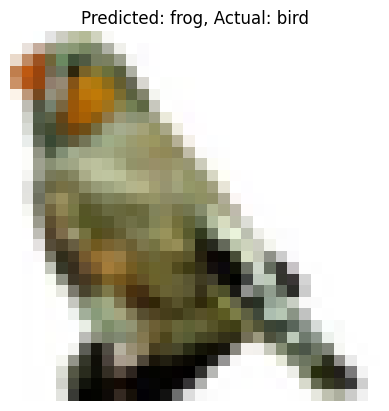

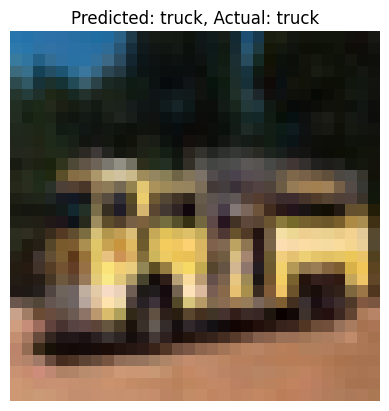

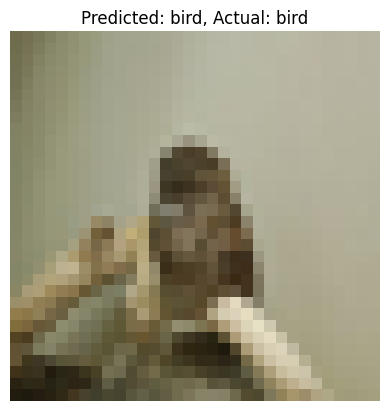

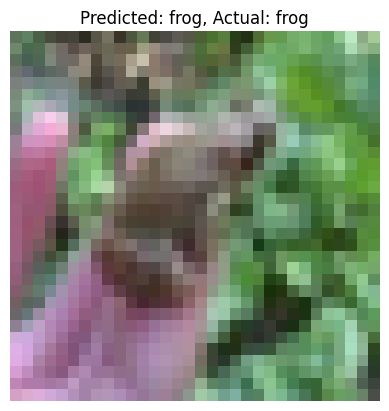

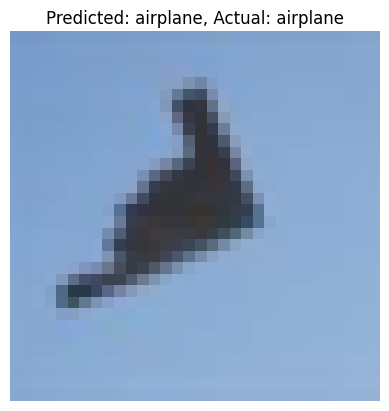

In [14]:
test_model_prediction(cnn_model, x_test, y_test, class_names)